In [14]:
using PyPlot, Polynomials, CoolProp, Roots

# Thermodynamics
This section finds the correlations for the density, viscosity, and partition coefficient (in water/oil) of DME.  
### Note: 
All the data in the Shell paper is reported as mole fraction. For convenience, I convert them to mass fraction, assuming the molecular weight of crude oil is equal to the molecular weight of C10H22.

## A detour: viscosity measurements
Is it possible to measure DME-water viscosity in a tube?

In [15]:
Re = 200 # Reynolds number
ρ  = 1000 # [kg/m^3] density
L = 1.0   # [m] pipe length
D = 0.001 # [m] pipe diameter
μ = 0.001 # [Pa.s]
v = Re*μ/(ρ*D) # velocity
q = v*π*D^2/4  # [m^3/s] flow rate
println("flow rate is $(q*1e6*60) ml/min")
dp = 8*μ*L*q/(π*(D/2)^4) # [Pa] pressure drop
println("pressure drop is $(dp/100) mbar")

flow rate is 9.42477796076938 ml/min
pressure drop is 63.99999999999999 mbar


In [16]:
# some data
MW_water = 0.018 # [kg/mol]
MW_oil   = 0.142 # [kg/mol]   
MW_DME   = 0.04607 # [kg/mol]

0.04607

## Density of DME-water and DME-oil

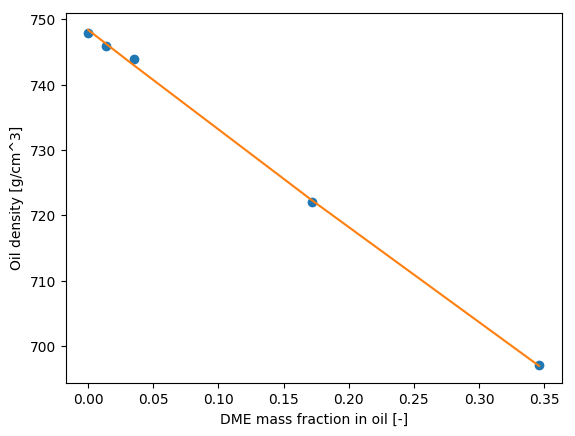

PyObject <matplotlib.text.Text object at 0x7f251d637490>

In [17]:
# Fig 4, SPE-177919, T = 70 degC, p = 2000 psi
x_DME_oil = [0.0, 0.04, 0.10, 0.39, 0.62]         # [mol frac]
w_DME_oil = MW_DME*x_DME_oil./(MW_DME*x_DME_oil+MW_oil*(1-x_DME_oil))
ρ_oil     = [0.748, 0.746, 0.744, 0.722, 0.697]*1000   # [g/cm^3]*1000 = [kg/m^3]

rho_fit = polyfit(w_DME_oil, ρ_oil, 2)

plot(w_DME_oil, ρ_oil, "o", w_DME_oil, polyval(rho_fit, w_DME_oil))
xlabel("DME mass fraction in oil [-]")
ylabel("Oil density [g/cm^3]")

## K-value

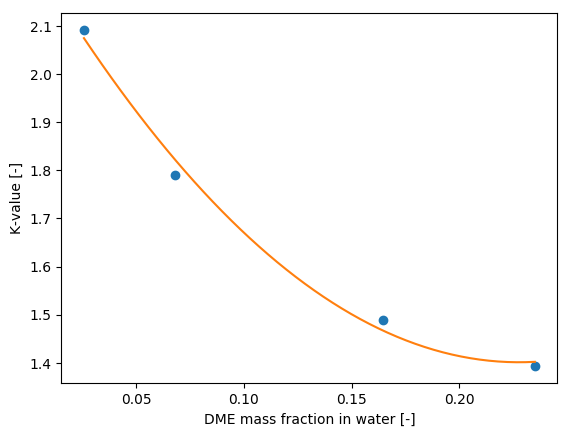

PyObject <matplotlib.text.Text object at 0x7f251c0afad0>

In [39]:
# experimental data from SPE-179771
# data for 1.4% brine and 71 degC and 2000 psia
x_DME_oil = [0.15, 0.30, 0.5, 0.6]   # [mol frac] [0.5, 13] is a madeup point
w_DME_oil = MW_DME*x_DME_oil./(MW_DME*x_DME_oil+MW_oil*(1-x_DME_oil)) # [mass frac]
K_value   = [17.0, 15.0, 13.0, 12.5]  # [-]
x_DME_water = x_DME_oil./K_value # [mole frac]
w_DME_water = MW_DME*x_DME_water./(MW_DME*x_DME_water+MW_water*(1-x_DME_oil))
K_value_mass = w_DME_oil./w_DME_water
K_fit = polyfit(w_DME_water, K_value_mass, 2)
w_DME_plot = collect(linspace(minimum(w_DME_water), maximum(w_DME_water), 50))
plot(w_DME_water, K_value_mass, "o", w_DME_plot, polyval(K_fit,w_DME_plot))
xlabel("DME mass fraction in water [-]")
ylabel("K-value [-]")

# viscosity

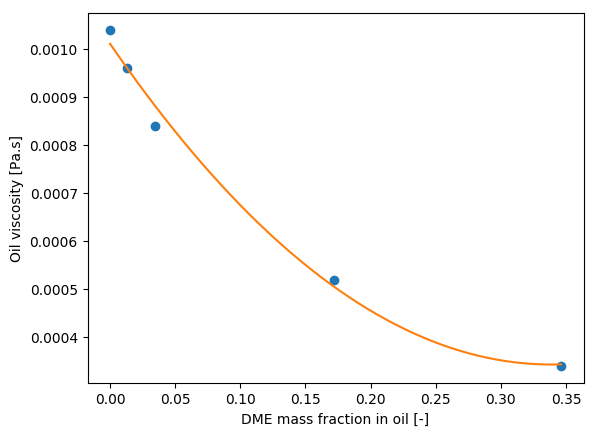

PyObject <matplotlib.text.Text object at 0x7f251c565c90>

In [32]:
# Fig 4, SPE-177919, T = 70 degC, p = 2000 psi
x_DME_oil = [0.0, 0.04, 0.10, 0.39, 0.62] # [mol frac]
w_DME_oil = MW_DME*x_DME_oil./(MW_DME*x_DME_oil+MW_oil*(1-x_DME_oil))
μ_oil = [1.04, 0.96, 0.84, 0.52, 0.34]/1000.0    # [cP]/1000 = [Pa.s]
mu_oil_fit = polyfit(w_DME_oil, μ_oil, 2)
w_DME_plot = collect(linspace(minimum(w_DME_oil), maximum(w_DME_oil), 50))
plot(w_DME_oil, μ_oil, "o", w_DME_plot, polyval(mu_oil_fit, w_DME_plot))
xlabel("DME mass fraction in oil [-]")
ylabel("Oil viscosity [Pa.s]")

For the viscosity of water with DME, I use the package coolprop to calculate the water viscosity at 70 degC and 2000 psi and assume a linear increase of viscosity when water is mixed with DME

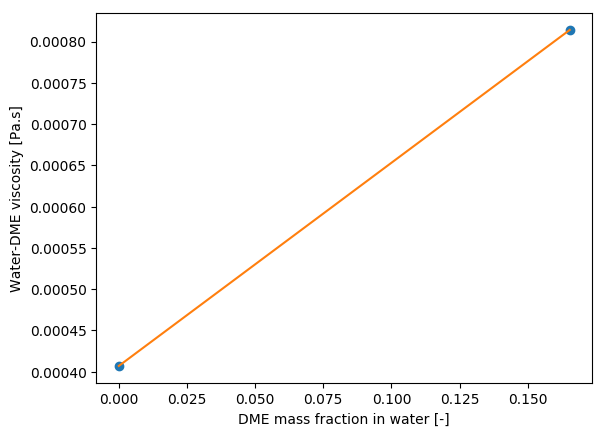

PyObject <matplotlib.text.Text object at 0x7f251d162d90>

In [20]:
T = 70 + 273.15 # [K] 
p = 2000/14.7*1e5   # [Pa]
mu_water = PropsSI("viscosity", "T", T, "P", p, "water") # [Pa.s]
mu_water_DME = [mu_water, 2*mu_water]
w_DME_water = [0.0, maximum(w_DME_oil)/maximum(K_value_mass)]
mu_water_fit = polyfit(w_DME_water, mu_water_DME, 1)
plot(w_DME_water, mu_water_DME, "o", w_DME_water, mu_water_fit(w_DME_water))
xlabel("DME mass fraction in water [-]")
ylabel("Water-DME viscosity [Pa.s]")

# The PDE's
All the PDE's are explained in the documents. In this section, I use the JFVM package to discretize them.

In [21]:
using JFVM
include("../rel_perms_real.jl")

d2pc_imb3

## Parameters

In [22]:
# T = 70 + 273.15 # [K] 
# p = 2000/14.7*1e5   # [Pa]
rho_water = PropsSI("D", "T", T, "P", p, "water")
# Corey rel-perm parameters
krw0 = 0.2
kro0 = 0.8
n_o  = 2.0
n_w  = 2.0
swc  = 0.08
sor  = 0.3
sorting_factor = 2.4
pce = 100 # [Pa]
pc0 = 1e5 # [Pa]
contact_angle = deg2rad(20) # [radian]

0.3490658503988659

## Utility functions

In [23]:
KRW  = sw -> krw(sw, krw0, sor, swc, n_w)
dKRW = sw -> dkrwdsw(sw, krw0, sor, swc, n_w)
KRO  = sw -> kro(sw, kro0, sor, swc, n_o)
dKRO = sw -> dkrodsw(sw, kro0, sor, swc, n_o)
# PC   = sw -> pc_imb(sw, pce, swc, sor, teta=contact_angle, 
#                 labda=sorting_factor, b = 0.0, pc01=pc0, pc02=pc0)
# dPC  = sw -> dpc_imb(sw, pce, swc, sor, teta=contact_angle, 
#                 labda1=sorting_factor, labda2=sorting_factor,
#                 b = 1.0, pc01=pc0, pc02=pc0)
# PC2  = sw -> pc_imb2(sw, pce, swc, sor, teta=contact_angle, 
#                 labda=sorting_factor, b = 0.0, pc_star1=pc0, 
#                 pc_star2=pc0)
# dPC2 = sw -> dpc_imb2(sw, pce, swc, sor, teta=contact_angle, 
#                 labda1=sorting_factor, labda2=sorting_factor, 
#                 b = 1.0, pc_star1=pc0, pc_star2=pc0)
PC  = sw -> pc_imb3(sw, pce, swc, sor, teta=contact_angle, 
                labda=sorting_factor, b = 0.0, pc_star1=pc0, 
                pc_star2=pc0)
dPC = sw -> dpc_imb3(sw, pce, swc, sor, teta=contact_angle, 
                labda1=sorting_factor, labda2=sorting_factor, 
                b = 1.0, pc_star1=pc0, pc_star2=pc0)
d2PC = sw -> d2pc_imb3(sw, pce, swc, sor, teta=contact_angle, 
                labda1=sorting_factor, labda2=sorting_factor, 
                b = 1.0, pc_star1=pc0, pc_star2=pc0)
# PCdrain2 = sw -> pc_drain2(sw, pce, swc, labda=sorting_factor, pc_star=pc0)
# PCdrain3 = sw -> pc_drain3(sw, pce, swc, labda=sorting_factor, pc_star=pc0)
ρ_oil = w_DME_oil -> polyval(rho_fit, w_DME_oil)
dρ_oil = w_DME_oil -> polyval(polyder(rho_fit), w_DME_oil)
μ_water = w_DME_water -> polyval(mu_water_fit, w_DME_water)
dμ_water = w_DME_water -> polyval(polyder(mu_water_fit), w_DME_water)
μ_oil = w_DME_oil -> polyval(mu_oil_fit, w_DME_oil)
dμ_oil = w_DME_oil -> polyval(polyder(mu_oil_fit), w_DME_oil)
Kval = w_DME_water -> polyval(K_fit, w_DME_water)
dKval = w_DME_water -> polyval(polyder(K_fit), w_DME_water)
dw_oil = w_DME_water -> polyval(Poly([0.0,1.0])*K_fit, x_DME_water)

(::#55) (generic function with 1 method)

In [47]:
Poly([0.0,1.0])*Poly([1.0,1.0])

Poly(1.0*x + 1.0*x^2)

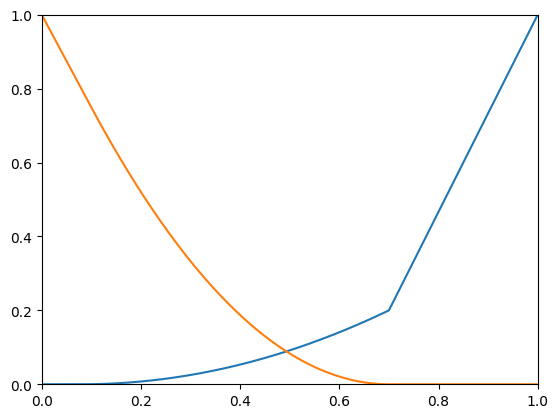

4-element Array{Int64,1}:
 0
 1
 0
 1

In [24]:
sw_plot = collect(linspace(0,1,1000))
plot(sw_plot, KRW.(sw_plot), sw_plot, KRO.(sw_plot))
axis([0,1,0,1])

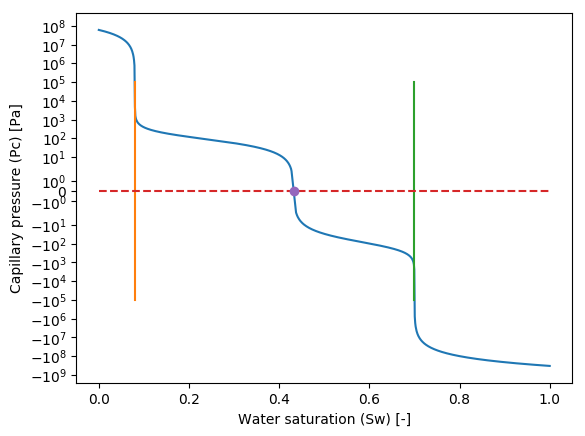

In [26]:
plot(sw_plot, PC.(sw_plot))
plot([swc, swc], [-pc0, pc0], [1-sor, 1-sor], [-pc0, pc0], 
    [0,1], [0,0], "--")
xlabel("Water saturation (Sw) [-]")
ylabel("Capillary pressure (Pc) [Pa]")
sw_imb_end = fzero(PC, [swc, 1-sor])
plot(sw_imb_end, 0, "o")
# axis([0, 1, -pc0, pc0])
yscale("symlog")

## domain

In [ ]:
Lx   = 1.0 # [m]
Nx  = 20  # number of grids in the x direction
m   = createMesh1D(Nx, Lx)

BCp = createBC(m) # pressure boundary condition
BCs = createBC(m) # saturation boundary condition
BCc = createBC(m) # concentration (DME in water) boundary condition

